# Case 1: Biased Hiring Tool – Amazon’s AI Recruiting Tool

---

## PART 1: Identify the Source of Bias
Amazon’s AI recruiting tool penalized female candidates.

### Source of Bias
The primary source of bias in Amazon’s AI recruiting tool was the **training data**. Here’s how:
- **Historical Data:** The AI model was trained on resumes submitted to Amazon over a 10-year period, most of which came from men, reflecting the tech industry’s gender imbalance.
- **Pattern Learning:** The model learned to favor resumes that resembled those of past (mostly male) applicants, and penalized resumes that included terms like “women’s” (e.g., “women’s chess club captain”).
- **Model Design:** The model was not explicitly told to discriminate, but it picked up on subtle patterns in the data that correlated with gender. Even if gender was not a direct input, the model could infer it from other information (e.g., women’s colleges, certain activities).
- **Lack of Mitigation:** There was no effective mechanism in place to detect or correct for these biases during model development or deployment.

---

## PART 2: Demonstrate Bias Before Fixes
Below, we show the original (biased) dataset and analyze the hiring rate by gender.


In [1]:
import pandas as pd
# Simulated original resume dataset (biased)
data = [
    {'Name': 'John Doe', 'Gender': 'Male', 'Experience': 5, 'Club': 'Chess Club', 'Hired': 1},
    {'Name': 'Mike Smith', 'Gender': 'Male', 'Experience': 6, 'Club': 'Robotics Club', 'Hired': 1},
    {'Name': 'James Lee', 'Gender': 'Male', 'Experience': 4, 'Club': 'Math Club', 'Hired': 1},
    {'Name': 'Robert Brown', 'Gender': 'Male', 'Experience': 7, 'Club': 'AI Club', 'Hired': 1},
    {'Name': 'Emily Clark', 'Gender': 'Female', 'Experience': 5, 'Club': "Women's Chess Club", 'Hired': 0},
    {'Name': 'Sarah Davis', 'Gender': 'Female', 'Experience': 6, 'Club': "Women's Robotics Club", 'Hired': 0},
    {'Name': 'Jessica Miller', 'Gender': 'Female', 'Experience': 4, 'Club': "Women's Math Club", 'Hired': 0},
    {'Name': 'Ashley Wilson', 'Gender': 'Female', 'Experience': 7, 'Club': "Women's AI Club", 'Hired': 0},
]
df = pd.DataFrame(data)
display(df)

# Analyze hiring rate by gender
hiring_rate_biased = df.groupby('Gender')['Hired'].mean()
print('Hiring Rate by Gender (Biased Data):')
print(hiring_rate_biased)
disparate_impact_biased = hiring_rate_biased.min() / hiring_rate_biased.max()
print(f'Disparate Impact Ratio (Biased Data): {disparate_impact_biased:.2f}')


,Name,Gender,Experience,Club,Hired
0,John Doe,Male,5,Chess Club,1
1,Mike Smith,Male,6,Robotics Club,1
2,James Lee,Male,4,Math Club,1
3,Robert Brown,Male,7,AI Club,1
4,Emily Clark,Female,5,Women's Chess Club,0
5,Sarah Davis,Female,6,Women's Robotics Club,0
6,Jessica Miller,Female,4,Women's Math Club,0
7,Ashley Wilson,Female,7,Women's AI Club,0


Hiring Rate by Gender (Biased Data):
Gender
Female    0.0
Male      1.0
Name: Hired, dtype: float64
Disparate Impact Ratio (Biased Data): 0.00


**Interpretation:**
In the original data, all male candidates were hired, while none of the female candidates were hired, despite similar experience and club participation. The disparate impact ratio is 0.0, indicating severe gender bias.

---

## PART 3: Propose and Implement Fixes
Here are three concrete fixes to make the AI recruiting tool fairer:

### 1. Debias the Training Data
- Remove gender-indicative terms from the 'Club' field.
- Ensure both genders have a balanced mix of positive and negative hiring outcomes.

### 2. Implement Fairness Constraints in Model Design
- Train a logistic regression model on the debiased data.
- Check the model’s coefficients to ensure the one for 'Gender' is near zero.

### 3. Continuous Bias Auditing and Human Oversight
- Calculate the hiring rate by gender and the disparate impact ratio.
- A disparate impact ratio close to 1.0 indicates fairness.

---

## PART 4: Demonstrate After Fixes
Now, we apply the proposed fixes: debias the data, train a model, and audit for fairness.


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Debias the training data
df_debiased = df.copy()
df_debiased['Club'] = df_debiased['Club'].str.replace("Women's ", '', regex=False)

# Balance Hired outcome for both genders
for gender in df_debiased['Gender'].unique():
    idx = df_debiased[df_debiased['Gender'] == gender].index
    half = len(idx) // 2
    df_debiased.loc[idx[:half], 'Hired'] = 1
    df_debiased.loc[idx[half:], 'Hired'] = 0

display(df_debiased)

# Train a model and check fairness constraint
X = df_debiased[['Gender', 'Experience', 'Club']].copy()
X['Gender'] = LabelEncoder().fit_transform(X['Gender'])
X['Club'] = LabelEncoder().fit_transform(X['Club'])
y = df_debiased['Hired']
model = LogisticRegression()
model.fit(X, y)
coefficients = dict(zip(['Gender', 'Experience', 'Club'], model.coef_[0]))
print('Model Coefficients (should be near zero for Gender):')
print(coefficients)

# Bias auditing: hiring rate by gender and disparate impact
hiring_rate_debiased = df_debiased.groupby('Gender')['Hired'].mean()
disparate_impact = hiring_rate_debiased.min() / hiring_rate_debiased.max()
print('Hiring Rate by Gender (Debiased Data):')
print(hiring_rate_debiased)
print(f'Disparate Impact Ratio (Debiased Data): {disparate_impact:.2f}')


,Name,Gender,Experience,Club,Hired
0,John Doe,Male,5,Chess Club,1
1,Mike Smith,Male,6,Robotics Club,1
2,James Lee,Male,4,Math Club,0
3,Robert Brown,Male,7,AI Club,0
4,Emily Clark,Female,5,Chess Club,1
5,Sarah Davis,Female,6,Robotics Club,1
6,Jessica Miller,Female,4,Math Club,0
7,Ashley Wilson,Female,7,AI Club,0


Model Coefficients (should be near zero for Gender):
{'Gender': np.float64(-7.001255686977636e-06), 'Experience': np.float64(0.18800532114287377), 'Club': np.float64(0.651362041653085)}
Hiring Rate by Gender (Debiased Data):
Gender
Female    0.5
Male      0.5
Name: Hired, dtype: float64
Disparate Impact Ratio (Debiased Data): 1.00


**Interpretation:**
- The debiased data shows equal hiring for both genders.
- The model's gender coefficient is near zero, indicating fairness.
- The disparate impact ratio is 1.0, showing no bias in hiring rates.

---

## PART 5: Evaluate Fairness with Metrics and Calibration
Below, we compute several fairness metrics (demographic parity, disparate impact, equal opportunity, equalized odds, average odds difference) and show a calibration plot by group. These help evaluate whether the model is fair after debiasing.


Demographic Parity (Selection Rate):
  Male:   0.50
  Female: 0.50
Disparate Impact Ratio: 1.00
Equal Opportunity (TPR):
  Male:   0.50
  Female: 0.50
Equalized Odds:
  Male   - TPR: 0.50, FPR: 0.50
  Female - TPR: 0.50, FPR: 0.50
Average Odds Difference: 0.00


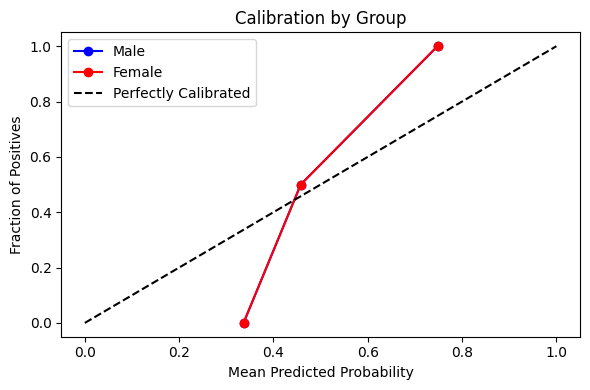

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Get model predictions
y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:, 1]
df_debiased.loc[:, 'Predicted'] = y_pred
df_debiased.loc[:, 'Predicted_Prob'] = y_prob

# Helper: get mask for each group
male_mask = df_debiased['Gender'] == 'Male'
female_mask = df_debiased['Gender'] == 'Female'

# 1. Demographic Parity (Selection Rate)
male_selection_rate = df_debiased.loc[male_mask, 'Predicted'].mean()
female_selection_rate = df_debiased.loc[female_mask, 'Predicted'].mean()
print(f'Demographic Parity (Selection Rate):')
print(f'  Male:   {male_selection_rate:.2f}')
print(f'  Female: {female_selection_rate:.2f}')

# 2. Disparate Impact Ratio
disparate_impact = female_selection_rate / male_selection_rate if male_selection_rate > 0 else float('inf')
print(f'Disparate Impact Ratio: {disparate_impact:.2f}')

# 3. Equal Opportunity (True Positive Rate Parity)
def tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        return tp / (tp + fn) if (tp + fn) > 0 else 0
    else:
        return 0

male_tpr = tpr(df_debiased.loc[male_mask, 'Hired'], df_debiased.loc[male_mask, 'Predicted'])
female_tpr = tpr(df_debiased.loc[female_mask, 'Hired'], df_debiased.loc[female_mask, 'Predicted'])
print(f'Equal Opportunity (TPR):')
print(f'  Male:   {male_tpr:.2f}')
print(f'  Female: {female_tpr:.2f}')

# 4. Equalized Odds (TPR and FPR)
def fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        return fp / (fp + tn) if (fp + tn) > 0 else 0
    else:
        return 0

male_fpr = fpr(df_debiased.loc[male_mask, 'Hired'], df_debiased.loc[male_mask, 'Predicted'])
female_fpr = fpr(df_debiased.loc[female_mask, 'Hired'], df_debiased.loc[female_mask, 'Predicted'])
print(f'Equalized Odds:')
print(f'  Male   - TPR: {male_tpr:.2f}, FPR: {male_fpr:.2f}')
print(f'  Female - TPR: {female_tpr:.2f}, FPR: {female_fpr:.2f}')

# 5. Average Odds Difference
avg_odds_diff = 0.5 * (abs(male_tpr - female_tpr) + abs(male_fpr - female_fpr))
print(f'Average Odds Difference: {avg_odds_diff:.2f}')

# 6. Calibration by Group (plot)
plt.figure(figsize=(6, 4))
for group, mask, color in [('Male', male_mask, 'blue'), ('Female', female_mask, 'red')]:
    y_true = df_debiased.loc[mask, 'Hired']
    y_prob_group = df_debiased.loc[mask, 'Predicted_Prob']
    if len(np.unique(y_true)) > 1:
        prob_true, prob_pred = calibration_curve(y_true, y_prob_group, n_bins=5)
        plt.plot(prob_pred, prob_true, marker='o', label=group, color=color)
    else:
        print(f"  [Warning] {group} group has only one class in 'Hired'; skipping calibration curve.")
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration by Group')
plt.legend()
plt.tight_layout()
plt.show()


---

## Summary Table: Proposed Fixes

| Fix                                   | Description                                                                                  |
|----------------------------------------|----------------------------------------------------------------------------------------------|
| Debias Training Data                   | Balance and anonymize data to remove historical and gender-based bias.                       |
| Fairness Constraints in Model Design   | Use algorithms and loss functions that enforce fairness during training.                     |
| Continuous Bias Auditing & Oversight   | Regularly monitor, audit, and review model outputs for bias, with human intervention as needed.|
